# **1 ЭТАП - Предобработка данных, формирование панели**

In [ ]:
import pandas as pd
import re

грузим экселевский файл с двумя листами, первый содержит собранные данные по отзывам, второй-макроэкономические показатели

In [ ]:
df_reviews = pd.read_excel('reviews_all.xlsx', sheet_name='Отзывы')
df_macro   = pd.read_excel('reviews_all.xlsx', sheet_name='Показатели')

In [ ]:
df_reviews

,source,chain,year,author,rating,text,reactions
0,Яндекс Карты,Золотое яблоко,2015.0,Вадим Кондратьев,2,"Магазин сам по себе хороший, ассортимент радуе...",0
1,Яндекс Карты,Золотое яблоко,2024.0,А,5,"Хороший ассортимент,нашла здесь марки,которых ...",0
2,Яндекс Карты,Золотое яблоко,2024.0,Виктория К,5,Большой магазин с хорошим ассортиментом.Вежлив...,0
3,Яндекс Карты,Золотое яблоко,2024.0,данил к.,5,"Отличный магазин, покупал жене подарок не на о...",0
4,Яндекс Карты,Золотое яблоко,2024.0,Григорий Букин.,5,"Магазин находится в центре города, очень уютна...",0
...,...,...,...,...,...,...,...
94055,Яндекс Карты,Подружка,2017.0,Венера Равзеева,5,Единственный хозяйственный магазин в Адмирал...,2
94056,Яндекс Карты,Подружка,2017.0,Инкогнито 1411,1,"Под товаром одна цена, а на кассе другая! И на...",3
94057,Яндекс Карты,Подружка,2017.0,Ринатовна,5,"Бываю иногда в этом магазине, ассортимент боль...",1
94058,Яндекс Карты,Подружка,2017.0,Dmitrii Tychkin,5,"большой выбор товаров, продавцы вежливые, очен...",2


In [ ]:
df_macro

,chain,year,revenue,cp_index,income_pop,FemaleShare
0,Золотое яблоко,2015,11.00,112.90,97.6,0.5367
1,Золотое яблоко,2016,13.00,105.40,95.5,0.5366
2,Золотое яблоко,2017,14.60,105.27,99.5,0.5364
3,Золотое яблоко,2018,15.20,101.62,100.7,0.5361
4,Золотое яблоко,2019,16.80,104.98,101.2,0.5359
...,...,...,...,...,...,...
85,Yves Rocher,2020,6.87,102.29,98.0,0.5358
86,Yves Rocher,2021,7.20,106.10,103.3,0.5355
87,Yves Rocher,2022,7.06,110.00,104.5,0.5349
88,Yves Rocher,2023,7.48,111.15,106.1,0.5352


перед агрегированием проверим уникальные названия

In [ ]:
# список уникальных сетей
chains = df_reviews['chain'].dropna().unique()    # массив numpy
print(chains)

# список уникальных сетей
chains = df_macro['chain'].dropna().unique()    # массив numpy
print(chains)

['Золотое яблоко' 'Иль де ботэ' "L'Occitane" '  Yves Rocher' 'Yves Rocher'
 'Рив Гош' 'Подружка' 'Лэтуаль' 'Улыбка радуги' 'Улыбка Радуги'
 'Магнит Косметик']
['Золотое яблоко' 'Иль де ботэ' 'Лэтуаль' 'Магнит Косметик' 'Подружка'
 'Рив Гош' 'Улыбка радуги' "L'Occitane" '  Yves Rocher']


приводим все к общему виду

In [ ]:
# Убираем лидирующие/трейлинг-пробелы и «выравниваем» регистр
# переводим всё в нижний регистр (удобно для сравнения)
df_reviews['chain_clean'] = (
    df_reviews['chain']
      .astype(str)                # на случай, если в столбце есть NaN и не-str
      .str.strip()                # обрезаем пробелы по краям
      .str.lower()                # переводим в нижний регистр
)
df_macro['chain_clean'] = (
    df_macro['chain']
      .astype(str)
      .str.strip()
      .str.lower()
)

# 3) Смотрим, какие уникальные значения получились после очистки
print('Отзывы (после очистки):', sorted(df_reviews['chain_clean'].unique()))
print('Показатели (после очистки):', sorted(df_macro['chain_clean'].unique()))


Отзывы (после очистки): ["l'occitane", 'yves rocher', 'золотое яблоко', 'иль де ботэ', 'лэтуаль', 'магнит косметик', 'подружка', 'рив гош', 'улыбка радуги']
Показатели (после очистки): ["l'occitane", 'yves rocher', 'золотое яблоко', 'иль де ботэ', 'лэтуаль', 'магнит косметик', 'подружка', 'рив гош', 'улыбка радуги']


In [ ]:
agg_reviews = (
    df_reviews
      .groupby(['chain_clean', 'year'])
      .agg(
          avg_rating = ('rating', 'mean'),
          review_vol = ('rating', 'size'),
          neg_share  = ('rating', lambda x: (x < 2).mean()),
          AvgLikes   = ('reactions', 'mean'),
          VarRating  = ('rating', 'var')
      )
      .reset_index()
)

df_ready = (
    agg_reviews
      .merge(df_macro, on=['chain_clean', 'year'], how='left')
      .sort_values(['chain_clean', 'year'])
)

df_ready

,chain_clean,year,avg_rating,review_vol,neg_share,AvgLikes,VarRating,chain,revenue,cp_index,income_pop,FemaleShare
0,l'occitane,2015.0,4.617021,47,0.042553,3.829787,0.893617,L'Occitane,3.14,112.90,97.6,0.5367
1,l'occitane,2016.0,4.331395,172,0.104651,2.302326,1.801816,L'Occitane,3.37,105.40,95.5,0.5366
2,l'occitane,2017.0,4.000000,20,0.150000,15.150000,2.105263,L'Occitane,3.57,105.27,99.5,0.5364
3,l'occitane,2018.0,3.880952,42,0.214286,2.666667,2.595238,L'Occitane,3.76,101.62,100.7,0.5361
4,l'occitane,2019.0,4.173554,121,0.123967,4.090909,1.894628,L'Occitane,4.20,104.98,101.2,0.5359
...,...,...,...,...,...,...,...,...,...,...,...,...
85,улыбка радуги,2020.0,4.487995,2957,0.031113,3.971931,0.856165,Улыбка радуги,20.10,102.29,98.0,0.5358
86,улыбка радуги,2021.0,4.548321,3932,0.033825,3.006104,0.868944,Улыбка радуги,23.20,106.10,103.3,0.5355
87,улыбка радуги,2022.0,4.476306,3714,0.057351,3.036080,1.156050,Улыбка радуги,27.70,110.00,104.5,0.5349
88,улыбка радуги,2023.0,4.602261,4689,0.033056,2.647899,0.842836,Улыбка радуги,36.00,111.15,106.1,0.5352


**тональность определяем**

In [ ]:
import pandas as pd
import re
import csv

# 1) Сначала собираем все рабочие строки через csv.reader
data = []
with open('rusentilex_2017.txt', 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',', quotechar='"')
    for row in reader:
        # row — это список строк между запятыми, при этом если поле было в кавычках,
        # то все запятые внутри сохраняются «внутри» одного элемента списка.

        # Пропускаем пустые строки или строки, начинающиеся с '!' (комментарии)
        if not row or row[0].startswith('!'):
            continue

        # После этого мы ожидаем, что в row как минимум 5 элементов:
        #   0: word
        #   1: pos
        #   2: lemma
        #   3: sentiment
        #   4: source
        #   5: ambiguity   (необязательно, может отсутствовать)
        if len(row) < 5:
            # Если у какой-то строки меньше пяти полей — пропустим её целиком
            # (скорее всего, это бракованная или неполная строка).
            continue

        word      = row[0].strip()
        pos       = row[1].strip()
        lemma     = row[2].strip()
        sentiment = row[3].strip()
        source    = row[4].strip()
        # Всё, что идёт после 5-го столбца (индекс 5), объединяем в одну строку ambiguity
        ambiguity = ''
        if len(row) > 5:
            ambiguity = ','.join(cell.strip() for cell in row[5:])

        data.append({
            'word':      word,
            'pos':       pos,
            'lemma':     lemma,
            'sentiment': sentiment,
            'source':    source,
            'ambiguity': ambiguity
        })

# 2) Собираем DataFrame из списка словарей
lex_df = pd.DataFrame(data)

# Проверяем первые несколько строк и общий размер
print(lex_df.head(10))
print(f"Всего строк (без комментариев и бракованных): {len(lex_df)}\n")

# 3) Переводим текстовую тональность в числовой скор (+1, −1, 0)
def sentiment_to_score(s: str) -> float:
    if s == 'positive':
        return 1.0
    elif s == 'negative':
        return -1.0
    else:
        # neutral или «positive/negative» → 0.0
        return 0.0

lex_df['score'] = lex_df['sentiment'].apply(sentiment_to_score)

# 4) Строим словарь {lemma: score}
lex_dict = {}
for _, row in lex_df.iterrows():
    lex_dict[row['lemma']] = row['score']

# 5) Функция лексиконного расчёта тональности для текста
try:
    from pymorphy2 import MorphAnalyzer
    morph = MorphAnalyzer()
    def lemmatize(token: str) -> str:
        return morph.parse(token)[0].normal_form
except ModuleNotFoundError:
    def lemmatize(token: str) -> str:
        return token

def calc_sentiment_simple(text: str, lex_dict: dict) -> float:
    """
    - Оставляем из текста только русские слова (только кириллица, без цифр и символов).
    - Лемматизируем каждый токен (если pymorphy2 установлен).
    - Берём из lex_dict оценку: +1, −1 или 0.
    - Возвращаем среднее арифметическое. Если лемм нет — 0.0.
    """
    if not isinstance(text, str) or not text.strip():
        return 0.0

    # Находим все подряд идущие кириллические символы (регистр не важен)
    tokens = re.findall(r'\b[а-яё]+\b', text.lower())
    lemmas = [lemmatize(tok) for tok in tokens]
    scores = [lex_dict.get(lemma, 0.0) for lemma in lemmas]
    return sum(scores) / len(scores) if scores else 0.0

df_reviews['sent_score'] = df_reviews['text'].fillna('').apply(
    lambda txt: calc_sentiment_simple(txt, lex_dict)
)

# Быстрая проверка
print(df_reviews[['text','sent_score']].head(10))
print("Мин/макс sent_score:", df_reviews['sent_score'].min(), "/", df_reviews['sent_score'].max())
print()

# 7) Группируем по цепочке и году, считая среднюю тональность
df_reviews['year'] = pd.to_numeric(df_reviews['year'], errors='coerce').astype('Int64')
df_reviews = df_reviews.dropna(subset=['year']).copy()
df_reviews['year'] = df_reviews['year'].astype(int)

df_sent = (
    df_reviews
      .groupby(['chain_clean', 'year'])
      .agg(avg_sentiment=('sent_score', 'mean'))
      .reset_index()
)

print(df_sent.head(10))

# 8) Объединяем полученную avg_sentiment с df_ready

df_ready = df_ready.merge(
    df_sent,
    on=['chain_clean', 'year'],
    how='left'
)
df_ready['avg_sentiment'] = df_ready['avg_sentiment'].fillna(0.0)

print("После merge df_ready.shape:", df_ready.shape)
print("Колонки df_ready:", df_ready.columns.tolist())


                word   pos              lemma sentiment   source ambiguity
0              аборт  Noun              аборт  negative     fact          
1         абортивный   Adj         абортивный  negative     fact          
2        абракадабра  Noun        абракадабра  negative  opinion          
3             абсурд  Noun             абсурд  negative  opinion          
4        абсурдность  Noun        абсурдность  negative  opinion          
5          абсурдный   Adj          абсурдный  negative  opinion          
6           авантюра  Noun           авантюра  negative  opinion          
7         авантюризм  Noun         авантюризм  negative  opinion          
8         авантюрист  Noun         авантюрист  negative  opinion          
9  авантюристический   Adj  авантюристический  negative  opinion          
Всего строк (без комментариев и бракованных): 16050

Примеры из lex_dict:
  аборт → -1.0
  абортивный → -1.0
  абракадабра → -1.0
  несуществующее → 0.0

                     

In [ ]:
# удаляем ненужные столбцы
df_ready = df_ready.drop(columns=['avg_sentiment_x', 'avg_sentiment_y', 'chain'])

df_ready

,chain_clean,year,avg_rating,review_vol,neg_share,AvgLikes,VarRating,revenue,cp_index,income_pop,FemaleShare,avg_sentiment
0,l'occitane,2015.0,4.617021,47,0.042553,3.829787,0.893617,3.14,112.90,97.6,0.5367,0.037580
1,l'occitane,2016.0,4.331395,172,0.104651,2.302326,1.801816,3.37,105.40,95.5,0.5366,0.047033
2,l'occitane,2017.0,4.000000,20,0.150000,15.150000,2.105263,3.57,105.27,99.5,0.5364,0.072223
3,l'occitane,2018.0,3.880952,42,0.214286,2.666667,2.595238,3.76,101.62,100.7,0.5361,0.033528
4,l'occitane,2019.0,4.173554,121,0.123967,4.090909,1.894628,4.20,104.98,101.2,0.5359,0.065656
...,...,...,...,...,...,...,...,...,...,...,...,...
85,улыбка радуги,2020.0,4.487995,2957,0.031113,3.971931,0.856165,20.10,102.29,98.0,0.5358,0.100069
86,улыбка радуги,2021.0,4.548321,3932,0.033825,3.006104,0.868944,23.20,106.10,103.3,0.5355,0.099553
87,улыбка радуги,2022.0,4.476306,3714,0.057351,3.036080,1.156050,27.70,110.00,104.5,0.5349,0.097303
88,улыбка радуги,2023.0,4.602261,4689,0.033056,2.647899,0.842836,36.00,111.15,106.1,0.5352,0.095269


In [ ]:
chain = df_ready['chain_clean'].unique()    # массив numpy
print(chain)

["l'occitane" 'yves rocher' 'золотое яблоко' 'иль де ботэ' 'лэтуаль'
 'магнит косметик' 'подружка' 'рив гош' 'улыбка радуги']


**Считаем индекс поисковой популярности с потмощью Google Trends и pytrends**

In [ ]:
!pip install pytrends

In [ ]:
import time
import pandas as pd
from pytrends.request import TrendReq
from pytrends.exceptions import TooManyRequestsError

# === Инициализация клиента Pytrends (локация RU, часовой пояс +3) ===
pytrends = TrendReq(hl='ru-RU', tz=180)

# === Список интересующих брендов (на русском, именно так ищут в Google) ===
brands = [
    'золотое яблоко', 'лэтуаль', 'рив гош', 'улыбка радуги',
    'магнит косметик', 'подружка', 'ив роше', 'локситан', 'иль де ботэ'
]

# === Разбиваем на чанки по 5 элементов (ограничение Google Trends) ===
chunks = [brands[i:i + 5] for i in range(0, len(brands), 5)]

# Здесь будем хранить годовые DataFrame для каждого чанка
dfs = []

# === Получаем тренды по каждому чанку с учётом 429 и задержек ===
for chunk in chunks:
    attempt = 0
    while attempt < 3:
        try:
            # Формируем запрос для текущей группы из 5 брендов
            pytrends.build_payload(chunk, timeframe='2015-01-01 2024-12-31', geo='RU')
            data = pytrends.interest_over_time()

            # Если Google Trends вернул пустой DataFrame, прерываем попытки для этого чанка
            if data.empty:
                break

            # Убираем служебный столбец 'isPartial', если он есть
            if 'isPartial' in data.columns:
                data = data.drop(columns=['isPartial'])

            # Ресемплинг к годовому разрешению (среднее из всех недель года)
            # Замечание: в будущих версиях pandas 'A' устаревший, но пока работает
            annual = data.resample('A').mean()
            dfs.append(annual)

            # Успешно получили данные → выходим из цикла попыток
            break

        except TooManyRequestsError:
            attempt += 1
            wait = 60  # ждем 60 секунд перед повторной попыткой
            print(f"Получили 429 Too Many Requests при запросе {chunk}. Попытка {attempt}/3. Ждём {wait} секунд...")
            time.sleep(wait)

    # После завершения попыток для этого чанка делаем паузу перед следующим
    time.sleep(30)  # 30 секунд между разными чанками

# Если не собралось ни одного DataFrame, прекращаем выполнение
if not dfs:
    raise RuntimeError("Не удалось получить данные ни для одного из чанков. Попробуйте позже.")

# === Объединяем все промежуточные DataFrame по ширине (axis=1) ===
combined = pd.concat(dfs, axis=1)

# === Преобразуем в «длинный» формат: brand, year, search_index ===
annual_long = (
    combined
      .reset_index()  # делаем из индекса (дата) колонку 'date'
      .melt(id_vars='date', var_name='brand', value_name='search_index')
      .assign(year=lambda df: df['date'].dt.year)
      .drop(columns=['date'])
      .reset_index(drop=True)
)

# Если нужно, можно сохранить результат в CSV:
# annual_long.to_csv('google_trends_annual.csv', index=False)

print("Полученные данные Google Trends (годовые):")
print(annual_long.head(10))


<ipython-input-50-d4a01a71fdba>:40: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual = data.resample('A').mean()
<ipython-input-50-d4a01a71fdba>:40: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual = data.resample('A').mean()


Полученные данные Google Trends (годовые):
            brand  search_index  year
0  золотое яблоко      6.583333  2015
1  золотое яблоко      6.833333  2016
2  золотое яблоко      7.750000  2017
3  золотое яблоко      9.166667  2018
4  золотое яблоко     19.083333  2019
5  золотое яблоко     38.333333  2020
6  золотое яблоко     35.916667  2021
7  золотое яблоко     45.250000  2022
8  золотое яблоко     57.000000  2023
9  золотое яблоко     71.666667  2024


In [ ]:
annual_long

,brand,search_index,year
0,золотое яблоко,6.583333,2015
1,золотое яблоко,6.833333,2016
2,золотое яблоко,7.750000,2017
3,золотое яблоко,9.166667,2018
4,золотое яблоко,19.083333,2019
...,...,...,...
85,иль де ботэ,28.500000,2020
86,иль де ботэ,18.583333,2021
87,иль де ботэ,9.500000,2022
88,иль де ботэ,13.166667,2023


**формируем итоговую панель**

In [ ]:


# Создадим словарь преобразования из названия brand → соответствующее значение chain_clean:
brand_to_chain = {
    'золотое яблоко': 'золотое яблоко',
    'лэтуаль':       'лэтуаль',
    'рив гош':       'рив гош',
    'улыбка радуги': 'улыбка радуги',
    'магнит косметик': 'магнит косметик',
    'подружка':       'подружка',
    'иль де ботэ':    'иль де ботэ',
    'ив роше':        'yves rocher',  # переводим "ив роше" → "yves rocher"
    'локситан':       "l'occitane"    # переводим "локситан" → "l'occitane"
}

# 3) Добавляем в annual_long столбец 'chain_clean' по этому словарю:
annual_long['chain_clean'] = annual_long['brand'].map(brand_to_chain)

# 4) Убираем все строки, где маппинг не сработал (chain_clean == NaN):
annual_long = annual_long.dropna(subset=['chain_clean']).copy()

# 5) Смотрим, что получилось
annual_long


,brand,search_index,year,chain_clean
0,золотое яблоко,6.583333,2015,золотое яблоко
1,золотое яблоко,6.833333,2016,золотое яблоко
2,золотое яблоко,7.750000,2017,золотое яблоко
3,золотое яблоко,9.166667,2018,золотое яблоко
4,золотое яблоко,19.083333,2019,золотое яблоко
...,...,...,...,...
85,иль де ботэ,28.500000,2020,иль де ботэ
86,иль де ботэ,18.583333,2021,иль де ботэ
87,иль де ботэ,9.500000,2022,иль де ботэ
88,иль де ботэ,13.166667,2023,иль де ботэ


In [ ]:
# 6) Теперь объединяем с df_ready по ключам ['chain_clean','year']:
df_ready = df_ready.merge(
    annual_long[['chain_clean', 'year', 'search_index']],
    on=['chain_clean', 'year'],
    how='left'  # left-merge, чтобы сохранить все 90 строк исходной панели
)

# 7) Если вдруг в каких-то сочетаниях (chain_clean, year) Google Trends не дал данных,
#    то в колонке 'search_index' будут NaN. Заполняем их нулём:
df_ready['search_index'] = df_ready['search_index'].fillna(0.0)

# 8) Проверяем результат:
print("Новая форма df_ready:", df_ready.shape)
print("Колонки df_ready:", df_ready.columns.tolist())

Новая форма df_ready: (90, 15)
Колонки df_ready: ['chain_clean', 'year', 'avg_rating', 'review_vol', 'neg_share', 'AvgLikes', 'VarRating', 'revenue', 'cp_index', 'income_pop', 'FemaleShare', 'avg_sentiment', 'search_index_x', 'search_index_y', 'search_index']


In [ ]:
df_ready = df_ready.drop(columns=['search_index_x', 'search_index_y'])

# Проверим, что осталась только одна колонка search_index:
print(df_ready.shape)         # Ожидаем (90, 13 или 14, в зависимости от остальных колонок)
print(df_ready.columns.tolist())

(90, 13)
['chain_clean', 'year', 'avg_rating', 'review_vol', 'neg_share', 'AvgLikes', 'VarRating', 'revenue', 'cp_index', 'income_pop', 'FemaleShare', 'avg_sentiment', 'search_index']


**ИТОГОВАЯ ПАНЕЛЬ**

In [ ]:
df_ready

,chain_clean,year,avg_rating,review_vol,neg_share,AvgLikes,VarRating,revenue,cp_index,income_pop,FemaleShare,avg_sentiment,search_index
0,l'occitane,2015.0,4.617021,47,0.042553,3.829787,0.893617,3.14,112.90,97.6,0.5367,0.037580,4.916667
1,l'occitane,2016.0,4.331395,172,0.104651,2.302326,1.801816,3.37,105.40,95.5,0.5366,0.047033,4.666667
2,l'occitane,2017.0,4.000000,20,0.150000,15.150000,2.105263,3.57,105.27,99.5,0.5364,0.072223,4.916667
3,l'occitane,2018.0,3.880952,42,0.214286,2.666667,2.595238,3.76,101.62,100.7,0.5361,0.033528,5.333333
4,l'occitane,2019.0,4.173554,121,0.123967,4.090909,1.894628,4.20,104.98,101.2,0.5359,0.065656,5.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,улыбка радуги,2020.0,4.487995,2957,0.031113,3.971931,0.856165,20.10,102.29,98.0,0.5358,0.100069,11.083333
86,улыбка радуги,2021.0,4.548321,3932,0.033825,3.006104,0.868944,23.20,106.10,103.3,0.5355,0.099553,10.000000
87,улыбка радуги,2022.0,4.476306,3714,0.057351,3.036080,1.156050,27.70,110.00,104.5,0.5349,0.097303,10.166667
88,улыбка радуги,2023.0,4.602261,4689,0.033056,2.647899,0.842836,36.00,111.15,106.1,0.5352,0.095269,8.750000


на всякий случай сохраняем результаты

In [ ]:
df_ready.to_csv('df_ready.csv', index=False)

In [ ]:
from google.colab import files
files.download('df_ready.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **2 ЭТАП - Описательная статистика**

In [ ]:
df_ready.describe()

,year,avg_rating,review_vol,neg_share,AvgLikes,VarRating,revenue,cp_index,income_pop,FemaleShare,avg_sentiment,search_index
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,2019.500000,3.952674,1043.977778,0.164717,4.165854,2.172079,40.938000,106.692000,101.370000,0.535840,0.056667,24.202778
std,2.888373,0.427709,1273.194964,0.098158,2.993060,0.760285,46.911849,3.508093,3.695653,0.000587,0.022168,18.079374
min,2015.000000,3.030303,20.000000,0.031113,0.687819,0.842836,3.140000,101.620000,95.500000,0.534900,0.004512,2.833333
25%,2017.000000,3.599442,181.750000,0.087772,2.460247,1.633675,9.207500,104.980000,98.000000,0.535300,0.045882,7.166667
50%,2019.500000,3.989213,438.000000,0.150238,3.142040,2.161127,22.550000,105.750000,100.950000,0.535850,0.055173,22.791667
75%,2022.000000,4.287779,1467.250000,0.228494,4.829631,2.845682,52.575000,110.000000,104.500000,0.536400,0.067861,38.020833
max,2024.000000,4.617021,5877.000000,0.388889,19.241379,3.463425,240.000000,112.900000,107.300000,0.536700,0.102755,74.750000


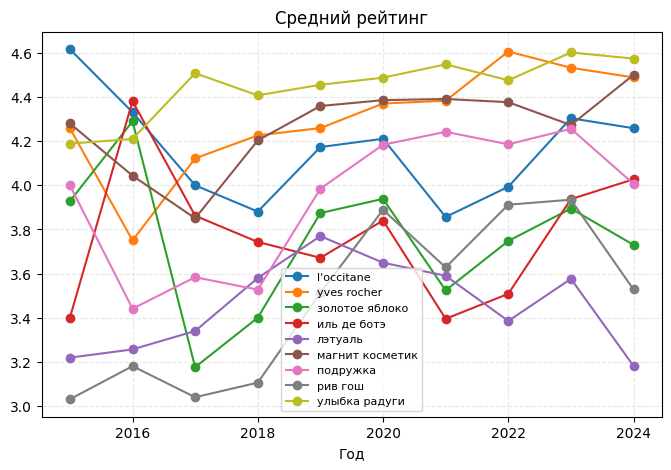

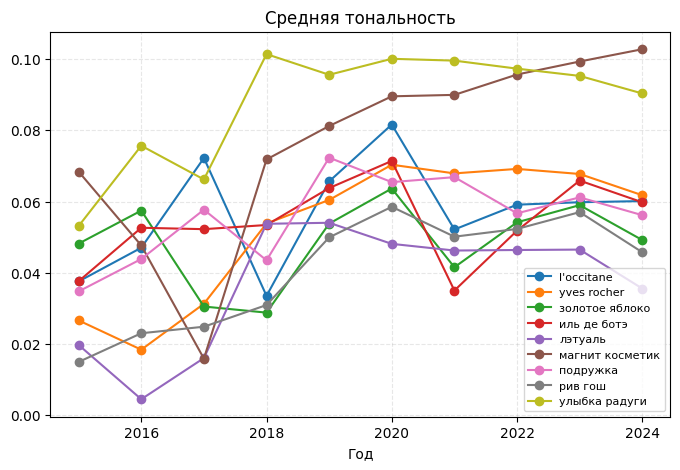

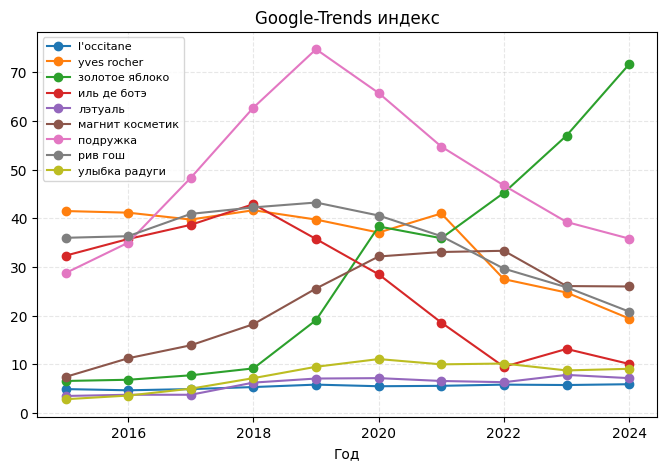

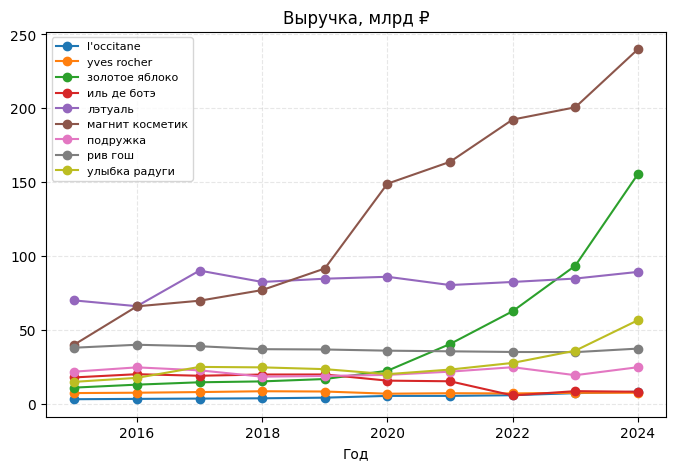

In [ ]:
import matplotlib.pyplot as plt

metrics = ['avg_rating', 'avg_sentiment', 'search_index', 'revenue']
titles  = ['Средний рейтинг', 'Средняя тональность',
           'Google-Trends индекс', 'Выручка, млрд ₽']

for col, title in zip(metrics, titles):
    plt.figure(figsize=(8,5))
    for chain, sub in df_ready.groupby('chain_clean'):
        plt.plot(sub['year'], sub[col], marker='o', label=chain)
    plt.title(title)
    plt.xlabel('Год')
    plt.grid(True, ls='--', alpha=.3)
    plt.legend(fontsize=8)
    plt.show()

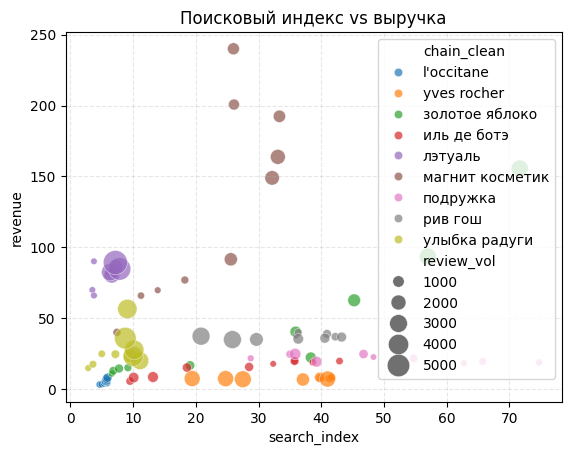

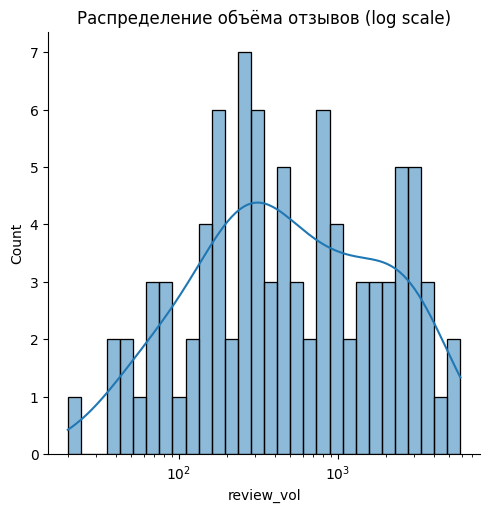

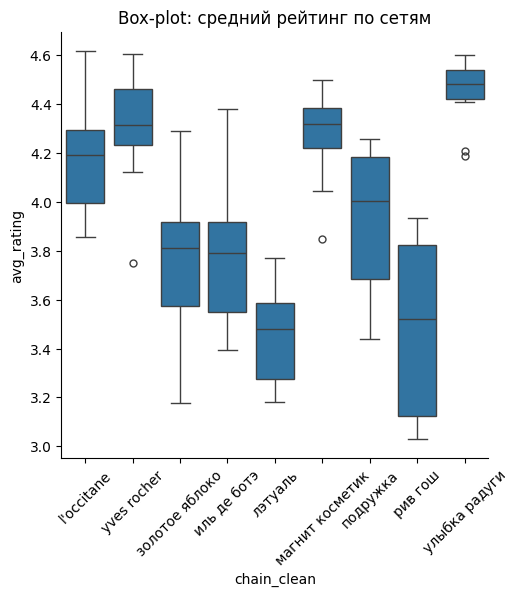

<ipython-input-67-f38e96295036>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=df_ready, x='chain_clean', y='avg_sentiment',


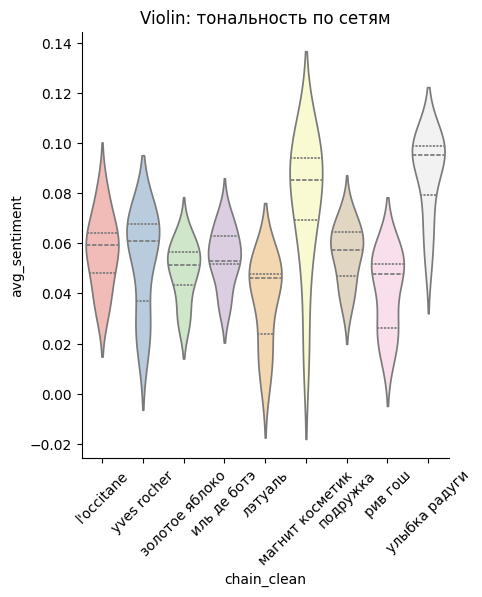

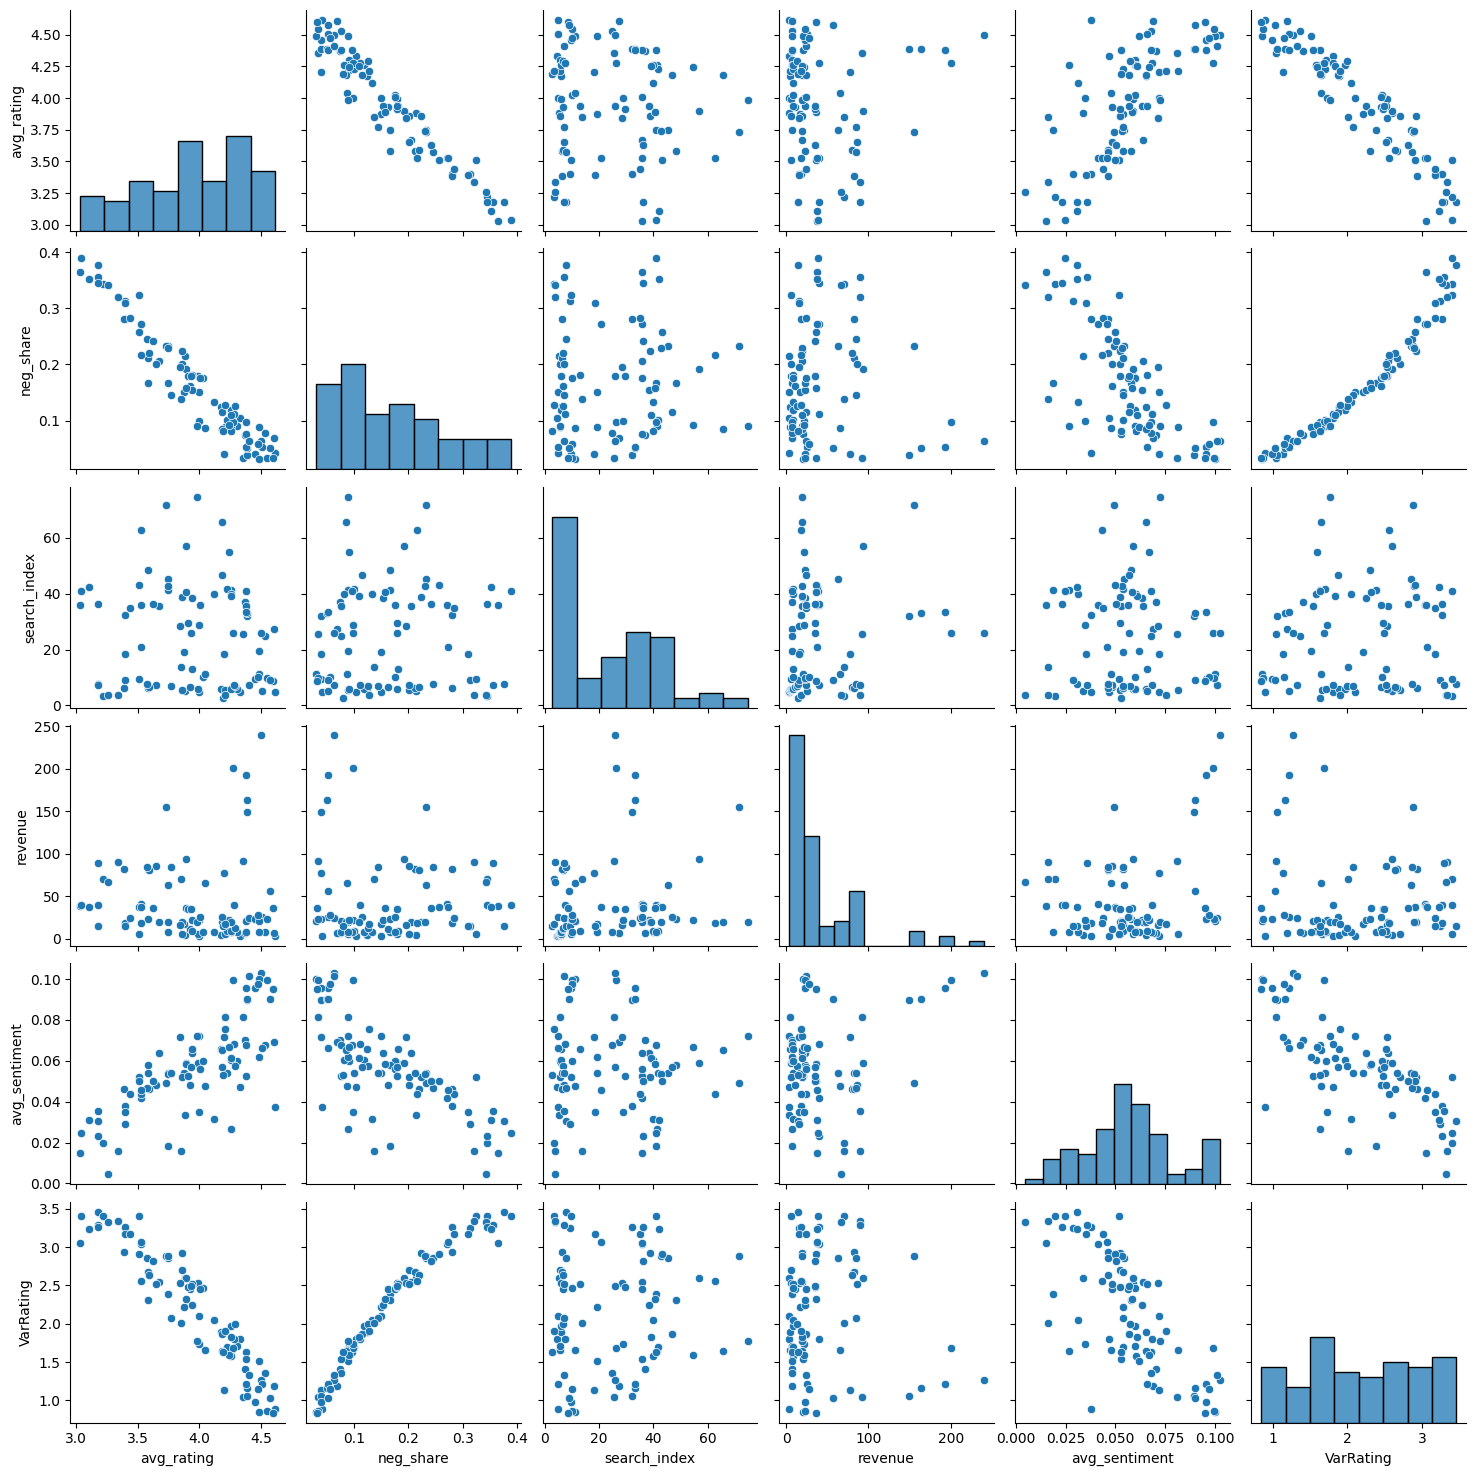

In [ ]:
# 1. Scatter: поиск ↔ выручка
sns.scatterplot(data=df_ready, x='search_index', y='revenue',
                hue='chain_clean', size='review_vol', sizes=(20,300), alpha=.7)
plt.title('Поисковый индекс vs выручка')
plt.grid(ls='--', alpha=.3)
plt.show()

# 2. Displot: распределение объёма отзывов (log-x)
sns.displot(df_ready['review_vol'], bins=30, log_scale=True, kde=True)
plt.title('Распределение объёма отзывов (log scale)')
plt.show()

# 3. Box-plot: рейтинг по сетям
sns.catplot(data=df_ready, x='chain_clean', y='avg_rating', kind='box')
plt.title('Box-plot: средний рейтинг по сетям')
plt.xticks(rotation=45)
plt.show()

# 4. Violin-plot: тональность по сетям
sns.catplot(data=df_ready, x='chain_clean', y='avg_sentiment',
            kind='violin', inner='quartile', palette='Pastel1')
plt.title('Violin: тональность по сетям')
plt.xticks(rotation=45)
plt.show()

# 5. Pair-plot (для пяти главных числовых переменных)
import seaborn as sns, matplotlib.pyplot as plt
subset = df_ready[['avg_rating','neg_share','search_index','revenue','avg_sentiment', 'VarRating']]
sns.pairplot(subset)
plt.show()


# **3 ЭТАП - корреляционный анализ данных**

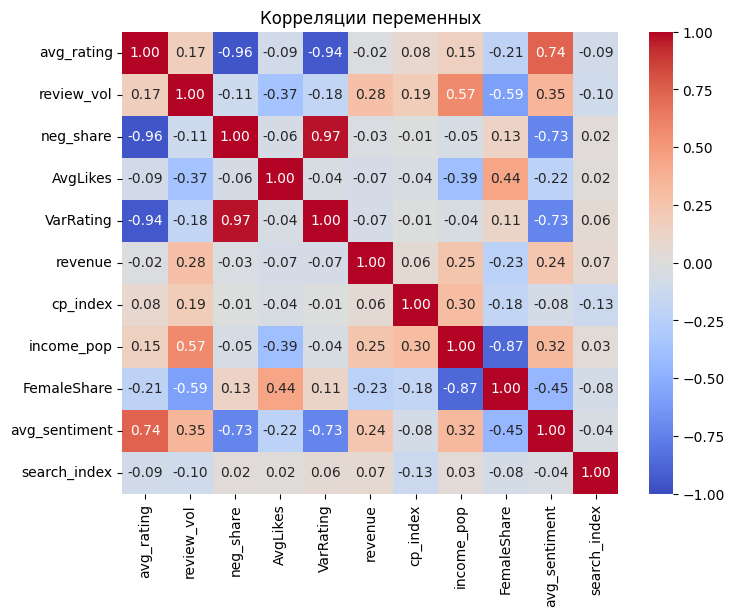

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
corr = df_ready.drop(columns=['chain_clean', 'year']).corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title('Корреляции переменных')
plt.show()


# **4 ЭТАП - Эконометрическое моделирование**

In [ ]:
import pandas as pd
df_ready = pd.read_csv('/content/df_ready.csv')
df_ready

,chain_clean,year,avg_rating,review_vol,neg_share,AvgLikes,VarRating,revenue,cp_index,income_pop,FemaleShare,avg_sentiment,search_index
0,l'occitane,2015.0,4.617021,47,0.042553,3.829787,0.893617,3.14,112.90,97.6,0.5367,0.037580,4.916667
1,l'occitane,2016.0,4.331395,172,0.104651,2.302326,1.801816,3.37,105.40,95.5,0.5366,0.047033,4.666667
2,l'occitane,2017.0,4.000000,20,0.150000,15.150000,2.105263,3.57,105.27,99.5,0.5364,0.072223,4.916667
3,l'occitane,2018.0,3.880952,42,0.214286,2.666667,2.595238,3.76,101.62,100.7,0.5361,0.033528,5.333333
4,l'occitane,2019.0,4.173554,121,0.123967,4.090909,1.894628,4.20,104.98,101.2,0.5359,0.065656,5.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,улыбка радуги,2020.0,4.487995,2957,0.031113,3.971931,0.856165,20.10,102.29,98.0,0.5358,0.100069,11.083333
86,улыбка радуги,2021.0,4.548321,3932,0.033825,3.006104,0.868944,23.20,106.10,103.3,0.5355,0.099553,10.000000
87,улыбка радуги,2022.0,4.476306,3714,0.057351,3.036080,1.156050,27.70,110.00,104.5,0.5349,0.097303,10.166667
88,улыбка радуги,2023.0,4.602261,4689,0.033056,2.647899,0.842836,36.00,111.15,106.1,0.5352,0.095269,8.750000


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [ ]:
df = df_ready.copy()

# 1) Целевая переменная
y = df['revenue']

# 2) Список «всех» предикторов
x = df[['search_index', 'avg_rating', 'VarRating', 'AvgLikes',
        'neg_share', 'avg_sentiment', 'review_vol',
        'cp_index', 'income_pop', 'FemaleShare']]

# 3) Добавляем константу (intercept)
x = sm.add_constant(x)

# 4) Строим OLS и смотрим summary
model = sm.OLS(y, x).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     2.537
Date:                Tue, 03 Jun 2025   Prob (F-statistic):             0.0105
Time:                        05:51:41   Log-Likelihood:                -461.01
No. Observations:                  90   AIC:                             944.0
Df Residuals:                      79   BIC:                             971.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4228.1420   9903.679     -0.427

# **Проверка предподпосылки о линейности модели по параметрам**

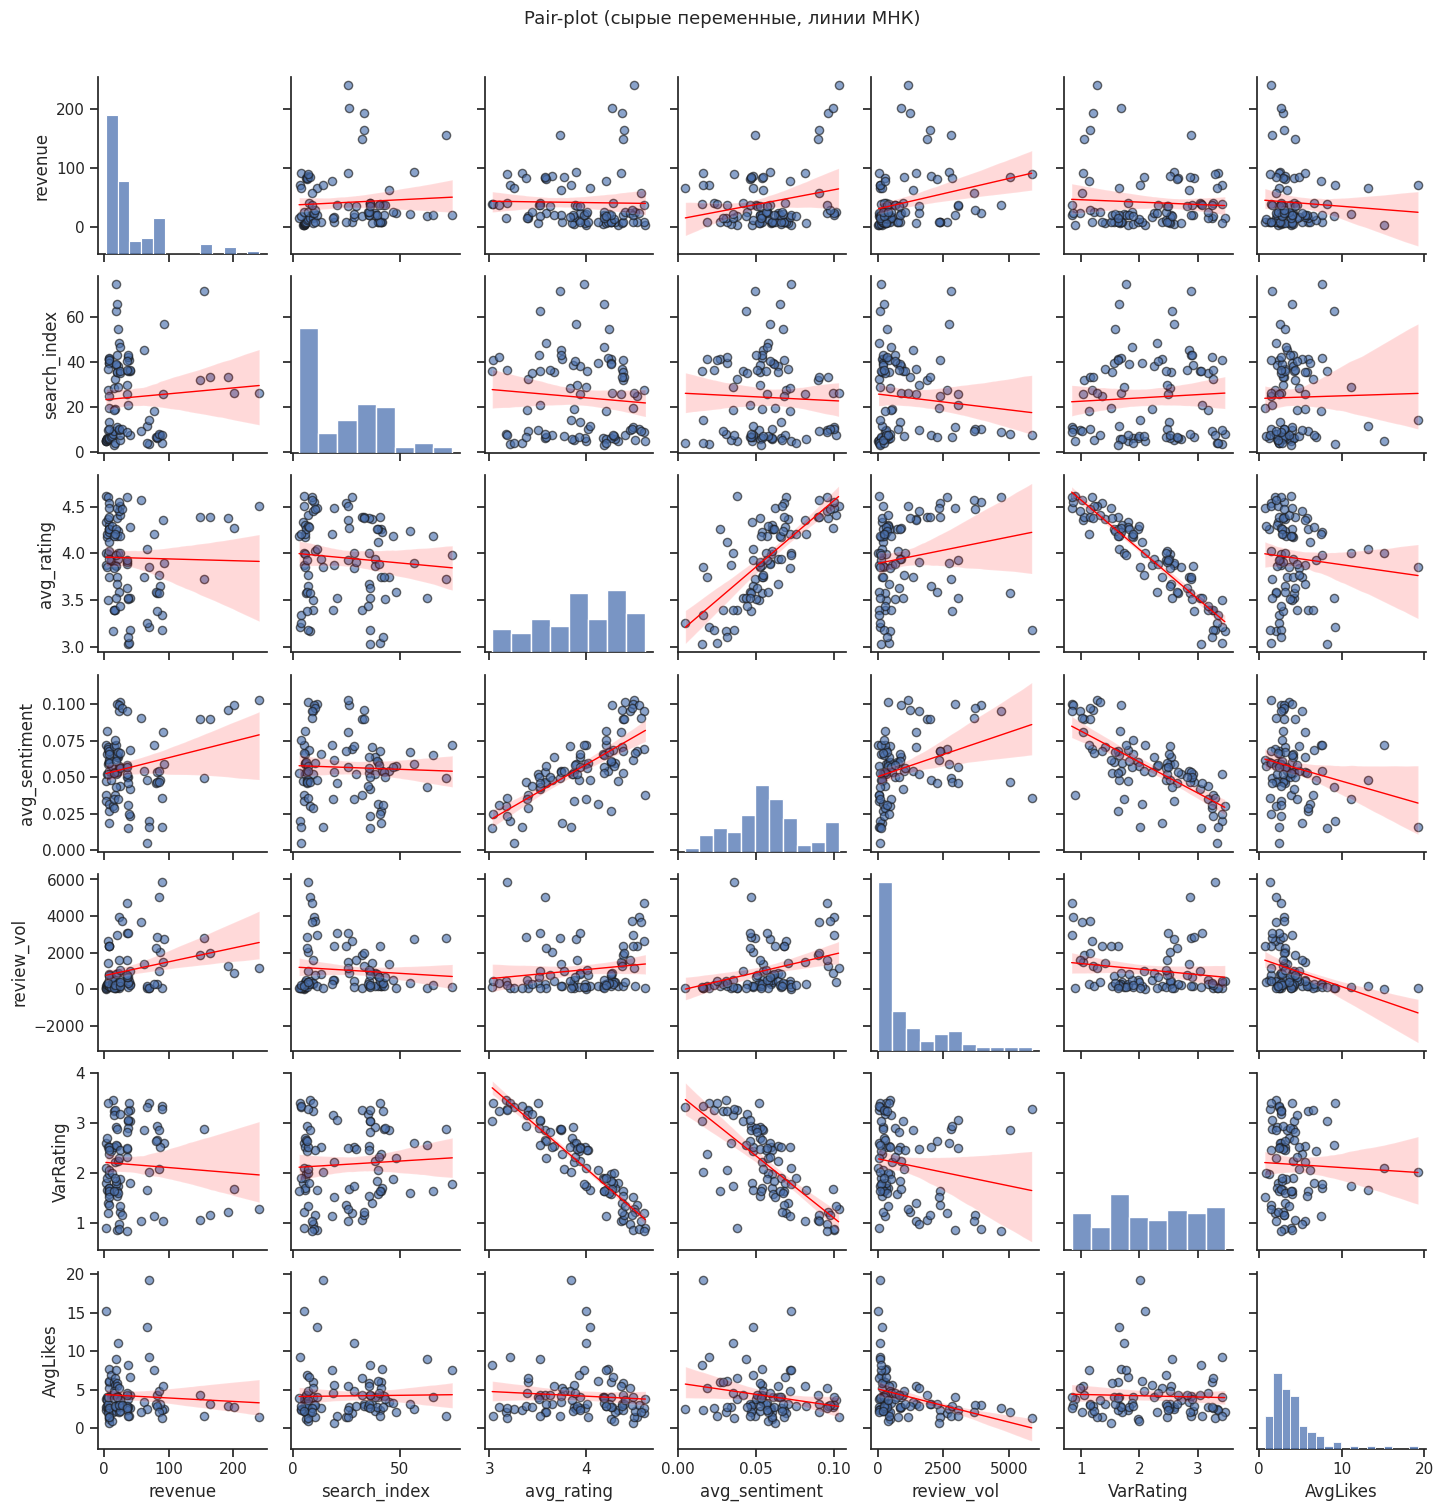

In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = df_ready.copy()


cols_raw = ['revenue',          # зависимая переменная
            'search_index',     # поисковый индекс
            'avg_rating',       # средний рейтинг
            'avg_sentiment',    # тональность
            'review_vol',       # объём отзывов
            'VarRating',        # дисперсия оценок
            'AvgLikes']         # средние лайки

df_raw = df[cols_raw].copy()


sns.set_theme(style='ticks', font_scale=1.0)

pair = sns.pairplot(df_raw,
                    kind='reg',           # рисуем линию MНК
                    diag_kind='hist',     # диагональ = гистограммы
                    height=2.1,
                    plot_kws={'scatter_kws': {'alpha': 0.65,
                                              'edgecolor': 'k',
                                              's': 35},
                              'line_kws':    {'color': 'red',
                                              'lw': 1}})

pair.fig.suptitle('Pair-plot (сырые переменные, линии МНК)', y=1.03, fontsize=13)
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import linear_reset, linear_rainbow
reset_raw = linear_reset(model, power=2, test_type='fitted')
print('RESET p-value (raw):', reset_raw.pvalue)
print('Rainbow p-value (raw):', linear_rainbow(model)[1])

RESET p-value (raw): 0.00974062472212725
Rainbow p-value (raw): 0.684877265339942


**логарифмируем переменные**

In [ ]:
df['ln_revenue']      = np.log(df['revenue'])
df['ln_search_index'] = np.log(df['search_index'] + 1)
df['ln_review_vol']   = np.log(df['review_vol'])

In [ ]:
y = df['ln_revenue']
X = df[['ln_search_index', 'avg_rating', 'avg_sentiment',
        'ln_review_vol', 'cp_index', 'income_pop', 'VarRating','AvgLikes']]
X = sm.add_constant(X)
model_log = sm.OLS(y, X).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_revenue   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     7.444
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           2.18e-07
Time:                        06:27:18   Log-Likelihood:                -107.02
No. Observations:                  90   AIC:                             232.0
Df Residuals:                      81   BIC:                             254.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              12.9537      4.279     

In [ ]:
from statsmodels.stats.diagnostic import linear_reset, linear_rainbow
print('RESET p:', linear_reset(model_log, power=2, test_type='fitted').pvalue)
print('Rainbow p:', linear_rainbow(model_log)[1])

RESET p: 0.6408936698495092
Rainbow p: 0.3544549880237338


# **Проверка предпосылки об отсутствии мультиколлинеарности**

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


X = df[['ln_search_index', 'avg_rating', 'avg_sentiment',
        'ln_review_vol', 'cp_index', 'income_pop',
        'VarRating', 'AvgLikes']].copy()

X = sm.add_constant(X)

# Считаем VIF
vif = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])]
})

# сортируем, чтобы самые «опасные» были сверху
vif = vif.sort_values(by='VIF', ascending=False).reset_index(drop=True)

print("Variance Inflation Factor (VIF):")
print(vif)


Variance Inflation Factor (VIF):
          Variable          VIF
0            const  2348.995905
1        VarRating    11.795267
2       avg_rating    11.112940
3    avg_sentiment     3.159151
4    ln_review_vol     2.357083
5       income_pop     2.145735
6         AvgLikes     1.606193
7         cp_index     1.261046
8  ln_search_index     1.063280


удаляем VarRating (дисперсию оценок)

In [ ]:
X_clean = df[['ln_search_index', 'avg_rating', 'avg_sentiment',
              'ln_review_vol', 'cp_index', 'income_pop', 'AvgLikes']].copy()

X_clean = sm.add_constant(X_clean)


y = df['ln_revenue']
model_clean = sm.OLS(y, X_clean).fit()
print(model_clean.summary())


                            OLS Regression Results                            
Dep. Variable:             ln_revenue   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     6.481
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           4.37e-06
Time:                        07:47:29   Log-Likelihood:                -112.00
No. Observations:                  90   AIC:                             240.0
Df Residuals:                      82   BIC:                             260.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.6330      3.738     

In [ ]:
# 3. Считаем новые VIF
vif_new = pd.DataFrame({
    'Variable': X_clean.columns,
    'VIF': [variance_inflation_factor(X_clean.values, i)
            for i in range(X_clean.shape[1])]
}).sort_values(by='VIF', ascending=False)

print("\nVIF после удаления VarRating:")
print(vif_new)


VIF после удаления VarRating:
          Variable          VIF
0            const  1624.450455
3    avg_sentiment     2.990369
2       avg_rating     2.420622
4    ln_review_vol     2.221314
6       income_pop     1.937811
7         AvgLikes     1.362099
5         cp_index     1.259042
1  ln_search_index     1.061431


# **Проверка предпосылки о нормальности распределения остатков**

In [ ]:
residuals = model_clean.resid.copy()      # вектор e = y – ŷ
print("n =", len(residuals), " mean(e) =", residuals.mean().round(4))

n = 90  mean(e) = 0.0


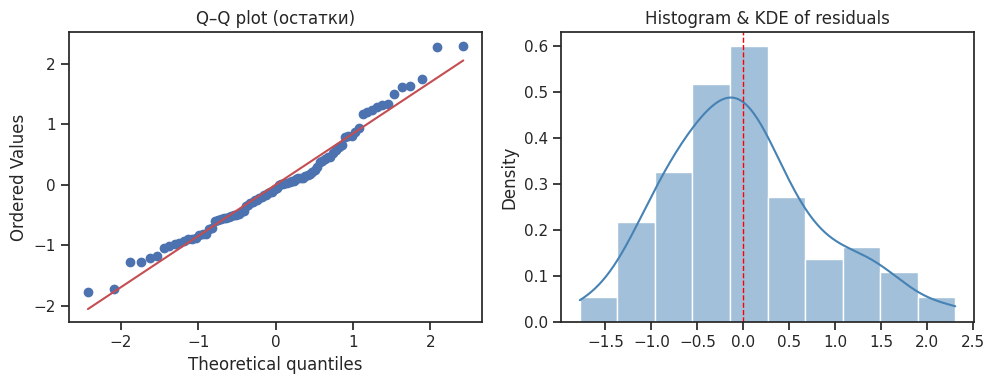

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# 2-A  Q-Q plot
st.probplot(residuals, plot=ax[0], fit=True)
ax[0].set_title('Q–Q plot (остатки)')

# 2-B  Гистограмма + KDE
sns.histplot(residuals, kde=True, stat='density', ax=ax[1], color='steelblue')
ax[1].set_title('Histogram & KDE of residuals')
ax[1].axvline(residuals.mean(), ls='--', c='red', lw=1)

plt.tight_layout(); plt.show()


In [ ]:
from statsmodels.stats.stattools import omni_normtest
omni_stat, omni_p = omni_normtest(residuals)
print(f"Omnibus  χ² = {omni_stat:.3f}   p-value = {omni_p:.4f}")

Omnibus  χ² = 4.707   p-value = 0.0950


In [ ]:
from scipy.stats import shapiro
w_stat, w_p = shapiro(residuals)
print(f"Shapiro-Wilk W = {w_stat:.3f}   p-value = {w_p:.4f}")

Shapiro-Wilk W = 0.974   p-value = 0.0709


In [ ]:
from scipy.stats import normaltest
k2_stat, k2_p = normaltest(residuals)
print(f"D’Agostino K² = {k2_stat:.3f}   p-value = {k2_p:.4f}")

D’Agostino K² = 4.707   p-value = 0.0950


Во всех случаях p-значения оказались значительно выше 0,05 (Omnibus p = 0,095; Shapiro p = 0,071; K² p = 0,095). Это означает, что нулевая гипотеза о нормальности ошибок не отвергается на стандартном уровне значимости

# **Проверка предпосылки о гомоскедастичности остатков**

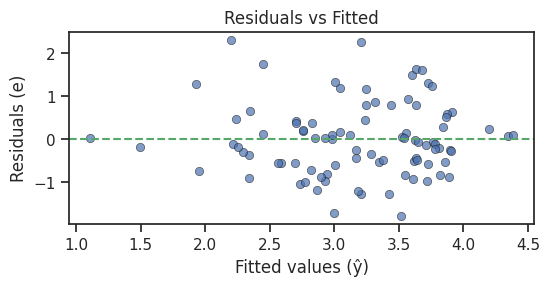

In [ ]:

pred_val = model_clean.fittedvalues.copy()   # ŷᵢ
residual = model_clean.resid.copy()          # eᵢ = yᵢ − ŷᵢ

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(6, 2.5))
plt.axhline(y=0, color='g', linestyle='--')  # горизонтальная линия в нуле

sns.scatterplot(x=pred_val, y=residual, alpha=0.7, edgecolor='k')
plt.xlabel('Fitted values (ŷ)')
plt.ylabel('Residuals (e)')
plt.title('Residuals vs Fitted')
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip

# Выполняем тест Бройша–Пагана
#   параметр 1: модель.resid  — вектор остатков eᵢ
#   параметр 2: модель.model.exog — исходная матрица X (включая константу)
bp_test = het_breuschpagan(model_clean.resid, model_clean.model.exog)

labels_bp = ['LM statistic', 'LM p‐value', 'F statistic', 'F p‐value']
print("Breusch–Pagan test results:", lzip(labels_bp, bp_test))

Breusch–Pagan test results: [('LM statistic', np.float64(11.346208744057929)), ('LM p‐value', np.float64(0.12421430371247615)), ('F statistic', np.float64(1.6898451921957456)), ('F p‐value', np.float64(0.1228839775010332))]


In [ ]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip

# Выполняем тест Уайта
#   параметр 1: модель.resid  — вектор остатков
#   параметр 2: модель.model.exog — матрица регрессоров
w_test = het_white(model_clean.resid, model_clean.model.exog)

labels_w = ['LM statistic', 'LM p‐value',
            'F statistic', 'F p‐value']
print("White test results:", lzip(labels_w, w_test))

White test results: [('LM statistic', np.float64(66.43203489452961)), ('LM p‐value', np.float64(0.001050606645321405)), ('F statistic', np.float64(4.3489176555072895)), ('F p‐value', np.float64(6.976196383131115e-07))]


# **Проверка предпосылки об отсутствии автокорреляции**

In [ ]:
import statsmodels.api as sm

residuals = model_clean.resid.copy()

# Вычисляем статистику Durbin–Watson
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)

print(f"Durbin–Watson statistic: {dw_stat:.3f}")


Durbin–Watson statistic: 0.547


dw_stat значительно ниже 1.5, то в остатках есть положительная автокорреляция – необходимо перейти к Breusch–Godfrey

In [ ]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.compat import lzip

# 1) Выполняем Breusch–Godfrey с, например, 3 запаздываниями (nlags=3)
bg_test = acorr_breusch_godfrey(model_clean, nlags=3)

labels_bg = ['LM statistic', 'LM p‐value', 'F statistic', 'F p‐value']
print("Breusch–Godfrey test:", lzip(labels_bg, bg_test))

Breusch–Godfrey test: [('LM statistic', np.float64(52.51009884667732)), ('LM p‐value', np.float64(2.3317651553044648e-11)), ('F statistic', 36.88369117434399), ('F p‐value', 5.2318738455734905e-15)]


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# 1) Вычисляем тест Ljung–Box для ряда остатков, оценивая автокорреляцию до лагов = 5
lb_test = acorr_ljungbox(model_clean.resid, lags=[5], return_df=True)

print("Ljung–Box test (lag=5):")
print(lb_test)

Ljung–Box test (lag=5):
     lb_stat     lb_pvalue
5  95.694521  4.264722e-19


# **5 ЭТАП - Переход к панельному подходу**

# **Pooled OLS (Модель пула, модель сквозной регрессии)**

In [ ]:
df_ready

,chain_clean,year,avg_rating,review_vol,neg_share,AvgLikes,VarRating,revenue,cp_index,income_pop,FemaleShare,avg_sentiment,search_index
0,l'occitane,2015.0,4.617021,47,0.042553,3.829787,0.893617,3.14,112.90,97.6,0.5367,0.037580,4.916667
1,l'occitane,2016.0,4.331395,172,0.104651,2.302326,1.801816,3.37,105.40,95.5,0.5366,0.047033,4.666667
2,l'occitane,2017.0,4.000000,20,0.150000,15.150000,2.105263,3.57,105.27,99.5,0.5364,0.072223,4.916667
3,l'occitane,2018.0,3.880952,42,0.214286,2.666667,2.595238,3.76,101.62,100.7,0.5361,0.033528,5.333333
4,l'occitane,2019.0,4.173554,121,0.123967,4.090909,1.894628,4.20,104.98,101.2,0.5359,0.065656,5.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,улыбка радуги,2020.0,4.487995,2957,0.031113,3.971931,0.856165,20.10,102.29,98.0,0.5358,0.100069,11.083333
86,улыбка радуги,2021.0,4.548321,3932,0.033825,3.006104,0.868944,23.20,106.10,103.3,0.5355,0.099553,10.000000
87,улыбка радуги,2022.0,4.476306,3714,0.057351,3.036080,1.156050,27.70,110.00,104.5,0.5349,0.097303,10.166667
88,улыбка радуги,2023.0,4.602261,4689,0.033056,2.647899,0.842836,36.00,111.15,106.1,0.5352,0.095269,8.750000


In [ ]:
df_ready['ln_revenue']      = np.log(df_ready['revenue'])
df_ready['ln_search_index'] = np.log(df_ready['search_index'] + 1)
df_ready['ln_review_vol']   = np.log(df_ready['review_vol'])
# Переведём в panel‐формат: MultiIndex [chain_clean, year]
df_panel = df_ready.set_index(['chain_clean', 'year'])


Panel shape: (90, 14)
                    ln_revenue  ln_search_index  avg_rating  avg_sentiment  \
chain_clean year                                                             
l'occitane  2015.0    1.144223         1.777773    4.617021       0.037580   
            2016.0    1.214913         1.734601    4.331395       0.047033   
            2017.0    1.272566         1.777773    4.000000       0.072223   
            2018.0    1.324419         1.845827    3.880952       0.033528   
            2019.0    1.435085         1.921813    4.173554       0.065656   

                    ln_review_vol  
chain_clean year                   
l'occitane  2015.0       3.850148  
            2016.0       5.147494  
            2017.0       2.995732  
            2018.0       3.737670  
            2019.0       4.795791  


In [ ]:
df_panel

avg_rating  review_vol  neg_share   AvgLikes  VarRating  \
chain_clean   year                                                              
l'occitane    2015.0    4.617021          47   0.042553   3.829787   0.893617   
              2016.0    4.331395         172   0.104651   2.302326   1.801816   
              2017.0    4.000000          20   0.150000  15.150000   2.105263   
              2018.0    3.880952          42   0.214286   2.666667   2.595238   
              2019.0    4.173554         121   0.123967   4.090909   1.894628   
...                          ...         ...        ...        ...        ...   
улыбка радуги 2020.0    4.487995        2957   0.031113   3.971931   0.856165   
              2021.0    4.548321        3932   0.033825   3.006104   0.868944   
              2022.0    4.476306        3714   0.057351   3.036080   1.156050   
              2023.0    4.602261        4689   0.033056   2.647899   0.842836   
              2024.0    4.574433        3661   0.051898   2.019940   1.028133   

                      revenue  cp_index  income_pop  FemaleShare  \
chain_clean   year                                                 
l'occitane    2015.0     3.14    112.90        97.6       0.5367   
              2016.0     3.37    105.40        95.5       0.5366   
              2017.0     3.57    105.27        99.5       0.5364   
              2018.0     3.76    101.62       100.7       0.5361   
              2019.0     4.20    104.98       101.2       0.5359   
...                       ...       ...         ...          ...   
улыбка радуги 2020.0    20.10    102.29        98.0       0.5358   
              2021.0    23.20    106.10       103.3       0.5355   
              2022.0    27.70    110.00       104.5       0.5349   
              2023.0    36.00    111.15       106.1       0.5352   
              2024.0    56.60    107.21       107.3       0.5353   

                      avg_sentiment  search_index  ln_revenue  \
chain_clean   year                                              
l'occitane    2015.0       0.037580      4.916667    1.144223   
              2016.0       0.047033      4.666667    1.214913   
              2017.0       0.072223      4.916667    1.272566   
              2018.0       0.033528      5.333333    1.324419   
              2019.0       0.065656      5.833333    1.435085   
...                             ...           ...         ...   
улыбка радуги 2020.0       0.100069     11.083333    3.000720   
              2021.0       0.099553     10.000000    3.144152   
              2022.0       0.097303     10.166667    3.321432   
              2023.0       0.095269      8.750000    3.583519   
              2024.0       0.090334      9.083333    4.036009   

                      ln_search_index  ln_review_vol  
chain_clean   year                                    
l'occitane    2015.0         1.777773       3.850148  
              2016.0         1.734601       5.147494  
              2017.0         1.777773       2.995732  
              2018.0         1.845827       3.737670  
              2019.0         1.921813       4.795791  
...                               ...            ...  
улыбка радуги 2020.0         2.491827       7.991931  
              2021.0         2.397895       8.276903  
              2022.0         2.412933       8.219865  
              2023.0         2.277267       8.452975  
              2024.0         2.310884       8.205492  

[90 rows x 14 columns]

In [ ]:
#  Pooled OLS (обычный OLS на всех наблюдениях)

# Определяем y и X точно так же, как в “PooledOLS”
y = df_panel['ln_revenue']
X = df_panel[['ln_search_index', 'avg_rating', 'avg_sentiment',
              'ln_review_vol', 'cp_index', 'income_pop', 'AvgLikes']].copy()

# Добавляем константу
X = sm.add_constant(X)

# Оцениваем OLS
pooled_model = sm.OLS(y, X).fit()

# Выводим результаты
print(pooled_model.summary())

# Вычислим Durbin–Watson, чтобы увидеть автокорреляцию остатков
dw = sm.stats.stattools.durbin_watson(pooled_model.resid)
print("\nDurbin–Watson statistic:", round(dw, 3))


                            OLS Regression Results                            
Dep. Variable:             ln_revenue   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     6.481
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           4.37e-06
Time:                        10:28:43   Log-Likelihood:                -112.00
No. Observations:                  90   AIC:                             240.0
Df Residuals:                      82   BIC:                             260.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.6330      3.738     

In [ ]:
# Pooled OLS с «робастными» стандартными ошибками

# Та же спецификация X и y, но fit с cov_type='HC3' (или 'HC1')
pooled_robust = pooled_model.get_robustcov_results(cov_type='HC3')

# Выводим результаты с робастными SE
print("=== Pooled OLS (robust SE) ===")
print(pooled_robust.summary())

=== Pooled OLS (robust SE) ===
                            OLS Regression Results                            
Dep. Variable:             ln_revenue   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     11.74
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           2.93e-10
Time:                        10:29:13   Log-Likelihood:                -112.00
No. Observations:                  90   AIC:                             240.0
Df Residuals:                      82   BIC:                             260.0
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const      

# **LSDV (least squares dummy variables model, модель с фиктивными переменными)**

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1) Загружаем df_ready.csv
df = pd.read_csv('df_ready.csv')

# 2) Логарифмируем тяжёлые переменные (если ещё нет):
df['ln_revenue']      = np.log(df['revenue'])
df['ln_search_index'] = np.log(df['search_index'] + 1)
df['ln_review_vol']   = np.log(df['review_vol'])

# 3) Создаём dummy для каждой сети (chain_clean)
dummies = pd.get_dummies(df['chain_clean'], prefix='d')

# 4) Приклеиваем dummy к df
df = pd.concat([df, dummies], axis=1)

# Посмотрим, что получилось
print("Список dummy‐столбцов:", dummies.columns.tolist())
print("Пример df с dummy:")
print(df[['chain_clean'] + dummies.columns.tolist()].head())


Список dummy‐столбцов: ["d_l'occitane", 'd_yves rocher', 'd_золотое яблоко', 'd_иль де ботэ', 'd_лэтуаль', 'd_магнит косметик', 'd_подружка', 'd_рив гош', 'd_улыбка радуги']
Пример df с dummy:
  chain_clean  d_l'occitane  d_yves rocher  d_золотое яблоко  d_иль де ботэ  \
0  l'occitane          True          False             False          False   
1  l'occitane          True          False             False          False   
2  l'occitane          True          False             False          False   
3  l'occitane          True          False             False          False   
4  l'occitane          True          False             False          False   

   d_лэтуаль  d_магнит косметик  d_подружка  d_рив гош  d_улыбка радуги  
0      False              False       False      False            False  
1      False              False       False      False            False  
2      False              False       False      False            False  
3      False              False     

In [ ]:
# 1) Выбираем «чистые» регрессоры, которыми будем оперировать
numeric_cols = [
    'ln_search_index', 'avg_rating', 'avg_sentiment',
    'ln_review_vol', 'cp_index', 'income_pop', 'AvgLikes'
]
X_i = df[numeric_cols].copy()

# 2) Добавляем константу
X_i = sm.add_constant(X_i)

# 3) Список dummy‐колонок и выбор «базовой» (чтобы не допустить dummy‐trap)
dummies_list = dummies.columns.tolist()
base_dummy = dummies_list[0]  # например, первая в списке

# 4) Добавляем остальные dummy, приводя их к int (0/1)
for col in dummies_list:
    if col != base_dummy:
        X_i[col] = df[col].astype(int)

# 5) Проверяем, что типы всех колонок теперь либо float64, либо int64
print("\nX_i.dtypes после конвертации:")
print(X_i.dtypes)

# 6) Определяем y и проверяем его dtype (должен быть float)
y = df['ln_revenue'].astype(float)
print("\nТип y:", y.dtype)


X_i.dtypes после конвертации:
const                float64
ln_search_index      float64
avg_rating           float64
avg_sentiment        float64
ln_review_vol        float64
cp_index             float64
income_pop           float64
AvgLikes             float64
d_yves rocher          int64
d_золотое яблоко       int64
d_иль де ботэ          int64
d_лэтуаль              int64
d_магнит косметик      int64
d_подружка             int64
d_рив гош              int64
d_улыбка радуги        int64
dtype: object

Тип y: float64


In [ ]:
X_i

,const,ln_search_index,avg_rating,avg_sentiment,ln_review_vol,cp_index,income_pop,AvgLikes,d_yves rocher,d_золотое яблоко,d_иль де ботэ,d_лэтуаль,d_магнит косметик,d_подружка,d_рив гош,d_улыбка радуги
0,1.0,1.777773,4.617021,0.037580,3.850148,112.90,97.6,3.829787,0,0,0,0,0,0,0,0
1,1.0,1.734601,4.331395,0.047033,5.147494,105.40,95.5,2.302326,0,0,0,0,0,0,0,0
2,1.0,1.777773,4.000000,0.072223,2.995732,105.27,99.5,15.150000,0,0,0,0,0,0,0,0
3,1.0,1.845827,3.880952,0.033528,3.737670,101.62,100.7,2.666667,0,0,0,0,0,0,0,0
4,1.0,1.921813,4.173554,0.065656,4.795791,104.98,101.2,4.090909,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1.0,2.491827,4.487995,0.100069,7.991931,102.29,98.0,3.971931,0,0,0,0,0,0,0,1
86,1.0,2.397895,4.548321,0.099553,8.276903,106.10,103.3,3.006104,0,0,0,0,0,0,0,1
87,1.0,2.412933,4.476306,0.097303,8.219865,110.00,104.5,3.036080,0,0,0,0,0,0,0,1
88,1.0,2.277267,4.602261,0.095269,8.452975,111.15,106.1,2.647899,0,0,0,0,0,0,0,1


In [ ]:
# 2) Оцениваем «сквозную» OLS‐модель с dummy‐переменными (LSDV по chain_clean)
pooled_with_dummies = sm.OLS(y, X_i).fit()

# 3) Выводим результаты
print("\n=== Pooled OLS с фиктивными переменными (LSDV по chain_clean) ===")
print(pooled_with_dummies.summary())



=== Pooled OLS с фиктивными переменными (LSDV по chain_clean) ===
                            OLS Regression Results                            
Dep. Variable:             ln_revenue   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     114.4
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           7.70e-45
Time:                        11:17:15   Log-Likelihood:                 11.531
No. Observations:                  90   AIC:                             8.939
Df Residuals:                      74   BIC:                             48.94
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

# **Fixed effects model (модель с фиксированными эффектами)**



In [ ]:
!pip install linearmodels -q

In [ ]:
#  Подготовка данных (мультииндекс + y и X)


import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS


df = pd.read_csv('df_ready.csv')


df['ln_revenue']      = np.log(df['revenue'])
df['ln_search_index'] = np.log(df['search_index'] + 1)
df['ln_review_vol']   = np.log(df['review_vol'])

# Создаём панель с мультииндексом (chain_clean, year)
df_panel = df.set_index(['chain_clean', 'year'])

# y = ln_revenue
y = df_panel['ln_revenue']

# «Полный» X (понадобится для FE по брендам)
X_full = df_panel[[
    'ln_search_index',
    'avg_rating',
    'avg_sentiment',
    'ln_review_vol',
    'cp_index',     # макро (только год)
    'income_pop',   # макро (только год)
    'AvgLikes'
]]

#  «Within»-X (без чисто-годовых макро) для FE(entity+time)
X_within = df_panel[[
    'ln_search_index',
    'avg_rating',
    'avg_sentiment',
    'ln_review_vol',
    'AvgLikes'
]]

# Кластеры для опциональной кластеризации SE:
clusters_entity = df_panel.index.get_level_values('chain_clean')
clusters_time   = df_panel.index.get_level_values('year')


In [ ]:

#  FE только по брендам (entity_effects=True)

model_FE_i = PanelOLS(
    y,
    X_full,             # здесь еще включены cp_index и income_pop
    entity_effects=True,
    time_effects=False, # годовых фиктивок нет
    drop_absorbed=True  # на всякий случай
)
result_FE_i = model_FE_i.fit()
print("=== FE (entity only) ===")
print(result_FE_i.summary)


=== FE (entity only) ===
                          PanelOLS Estimation Summary                           
Dep. Variable:             ln_revenue   R-squared:                        0.7337
Estimator:                   PanelOLS   R-squared (Between):             -0.1037
No. Observations:                  90   R-squared (Within):               0.7337
Date:                Tue, Jun 03 2025   R-squared (Overall):             -0.0910
Time:                        13:20:17   Log-likelihood                    11.531
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      29.133
Entities:                           9   P-value                           0.0000
Avg Obs:                      10.0000   Distribution:                    F(7,74)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             29.133
   

In [ ]:

# FE по брендам и годам (entity_effects=True, time_effects=True)

model_FE_it = PanelOLS(
    y,
    X_within,           # убрали cp_index и income_pop, чтобы избежать коллинеарности с year dummies
    entity_effects=True,
    time_effects=True,
    drop_absorbed=True
)
result_FE_it = model_FE_it.fit()
print("=== FE (entity+time) без cp_index & income_pop ===")
print(result_FE_it.summary)


=== FE (entity+time) без cp_index & income_pop ===
                          PanelOLS Estimation Summary                           
Dep. Variable:             ln_revenue   R-squared:                        0.7519
Estimator:                   PanelOLS   R-squared (Between):              0.6516
No. Observations:                  90   R-squared (Within):               0.5581
Date:                Tue, Jun 03 2025   R-squared (Overall):              0.6502
Time:                        13:02:11   Log-likelihood                    25.721
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      40.603
Entities:                           9   P-value                           0.0000
Avg Obs:                      10.0000   Distribution:                    F(5,67)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robus

In [ ]:

#   FE (entity+time) + clustered SE по брендам

model_FE_cluster_ent = PanelOLS(
    y,
    X_within,
    entity_effects=True,
    time_effects=True,
    drop_absorbed=True
)
result_FE_cluster_ent = model_FE_cluster_ent.fit(
    cov_type='clustered',
    cluster_entity=True
)
print("=== FE (entity+time) + clustered SE по chain_clean ===")
print(result_FE_cluster_ent.summary)

=== FE (entity+time) + clustered SE по chain_clean ===
                          PanelOLS Estimation Summary                           
Dep. Variable:             ln_revenue   R-squared:                        0.7519
Estimator:                   PanelOLS   R-squared (Between):              0.6516
No. Observations:                  90   R-squared (Within):               0.5581
Date:                Tue, Jun 03 2025   R-squared (Overall):              0.6502
Time:                        13:02:36   Log-likelihood                    25.721
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      40.603
Entities:                           9   P-value                           0.0000
Avg Obs:                      10.0000   Distribution:                    F(5,67)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (r

In [ ]:

#  FE (entity+time) + clustered SE по годам

model_FE_cluster_time = PanelOLS(
    y,
    X_within,
    entity_effects=True,
    time_effects=True,
    drop_absorbed=True
)
result_FE_cluster_time = model_FE_cluster_time.fit(
    cov_type='clustered',
    cluster_time=True
)
print("=== FE (entity+time) + clustered SE по year ===")
print(result_FE_cluster_time.summary)


=== FE (entity+time) + clustered SE по year ===
                          PanelOLS Estimation Summary                           
Dep. Variable:             ln_revenue   R-squared:                        0.7519
Estimator:                   PanelOLS   R-squared (Between):              0.6516
No. Observations:                  90   R-squared (Within):               0.5581
Date:                Tue, Jun 03 2025   R-squared (Overall):              0.6502
Time:                        13:02:54   Log-likelihood                    25.721
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      40.603
Entities:                           9   P-value                           0.0000
Avg Obs:                      10.0000   Distribution:                    F(5,67)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):

# **Random effects model (модель со случайными эффектами)**

In [ ]:
df_panel = df_ready.set_index(['chain_clean', 'year']).sort_index()
# На этом этапе в индексе у нас (бренд, год).
# Убедимся, что в df_panel есть нужные колонки:
print(df_panel[['ln_revenue', 'ln_search_index', 'avg_rating', 'avg_sentiment',
                'ln_review_vol', 'cp_index', 'income_pop', 'AvgLikes']].head())
# Выведем размеры и типы:
print("Shape df_panel:", df_panel.shape)
print(df_panel.dtypes)

                    ln_revenue  ln_search_index  avg_rating  avg_sentiment  \
chain_clean year                                                             
l'occitane  2015.0    1.144223         1.777773    4.617021       0.037580   
            2016.0    1.214913         1.734601    4.331395       0.047033   
            2017.0    1.272566         1.777773    4.000000       0.072223   
            2018.0    1.324419         1.845827    3.880952       0.033528   
            2019.0    1.435085         1.921813    4.173554       0.065656   

                    ln_review_vol  cp_index  income_pop   AvgLikes  
chain_clean year                                                    
l'occitane  2015.0       3.850148    112.90        97.6   3.829787  
            2016.0       5.147494    105.40        95.5   2.302326  
            2017.0       2.995732    105.27        99.5  15.150000  
            2018.0       3.737670    101.62       100.7   2.666667  
            2019.0       4.795791    10

In [ ]:
# Задаём y и X:
y = df_panel['ln_revenue']            # зависимая переменная: логарифм выручки
X = df_panel[['ln_search_index',      # логарифм поискового индекса
              'avg_rating',
              'avg_sentiment',
              'ln_review_vol',       # логарифм объёма отзывов
              'cp_index',            # годовой CPI
              'income_pop',          # годовые реальные доходы населения
              'AvgLikes'             # среднее число откликов
             ]].copy()


X = sm.add_constant(X)


In [ ]:
from linearmodels.panel import RandomEffects

In [ ]:
# 1) Создаём модель RandomEffects
model_RE = RandomEffects(dependent=y, exog=X)

# 2) Оцениваем её «обычным» fit() (без кластеризации):
result_RE = model_RE.fit()

# 3) Выводим полный summary:
print(result_RE)

                        RandomEffects Estimation Summary                        
Dep. Variable:             ln_revenue   R-squared:                        0.6623
Estimator:              RandomEffects   R-squared (Between):             -0.3483
No. Observations:                  90   R-squared (Within):               0.7318
Date:                Tue, Jun 03 2025   R-squared (Overall):             -0.1805
Time:                        13:43:33   Log-likelihood                   -2.1543
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      22.977
Entities:                           9   P-value                           0.0000
Avg Obs:                      10.0000   Distribution:                    F(7,82)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             22.977
                            

# **Сравнение моделей**

In [ ]:
# 1) Импортируем функцию compare из linearmodels.panel
from linearmodels.panel import compare

# 2) Собираем словарь «имя_модели : результат_модели»
#    Названия «ключей» можно подобрать любые, но лучше — как в лекции:
all_models = {

    'FE (entity only)':                  result_FE_i,
    'FE (entity+time)':                 result_FE_it,
    'FE (entity+time clustered entity)': result_FE_cluster_ent,
    'FE (entity+time clustered time)':   result_FE_cluster_time,
    'Random Effects':                    result_RE
}

# 3) Вызываем compare и сразу печатаем итоговую таблицу
#    precision='std_errors' указывает, что в сравнении коэффициентов мы хотим видеть
#    стандартные ошибки с одним десятичным знаком (или два, на ваше усмотрение).
results_compare = compare(all_models, precision='std_errors', stars=True)

print(results_compare)


                                                               Model Comparison                                                              
                        FE (entity only) FE (entity+time) FE (entity+time clustered entity) FE (entity+time clustered time)    Random Effects
---------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable                 ln_revenue       ln_revenue                        ln_revenue                      ln_revenue        ln_revenue
Estimator                       PanelOLS         PanelOLS                          PanelOLS                        PanelOLS     RandomEffects
No. Observations                      90               90                                90                              90                90
Cov. Est.                     Unadjusted       Unadjusted                         Clustered                       Clustered        Unadjusted
R-squa

In [ ]:
import numpy as np
from scipy.stats import chi2

# Считаем, что result_FE_i – это «FE (entity only)»,
# а result_RE – это «Random Effects» на тех же самых данных:
beta_FE = result_FE_i.params
beta_RE = result_RE.params

cov_FE = result_FE_i.cov
cov_RE = result_RE.cov

# Находим «пересечение» имён коэффициентов у FE и RE
common_idx = beta_FE.index.intersection(beta_RE.index)

# Берём только эти общие параметры
beta_FE_c = beta_FE.loc[common_idx]
beta_RE_c = beta_RE.loc[common_idx]

cov_FE_c  = cov_FE.loc[common_idx, common_idx]
cov_RE_c  = cov_RE.loc[common_idx, common_idx]

# Разница коэффициентов и разность ковариационных матриц
diff = beta_FE_c - beta_RE_c
cov_diff = cov_FE_c - cov_RE_c

# Проверяем, что cov_diff невырождена (иначе np.linalg.inv выдаст ошибку)
# Если после вычитания она всё ещё сингулярна, можно взять псевдо-инверсию через np.linalg.pinv.
cov_diff_inv = np.linalg.inv(cov_diff)

# Теперь считаем статистику Хаусмана
hausman_stat = float(diff.T @ cov_diff_inv @ diff)

# Число степеней свободы = количество сравниваемых параметров
dof = len(common_idx)

p_value = 1 - chi2.cdf(hausman_stat, dof)

print(f"Общие параметры: {list(common_idx)}")
print(f"Статистика Хаусмана: {hausman_stat:.3f}")
print(f"p-value: {p_value:.4f}")


Общие параметры: ['ln_search_index', 'avg_rating', 'avg_sentiment', 'ln_review_vol', 'cp_index', 'income_pop', 'AvgLikes']
Статистика Хаусмана: -3.062
p-value: 1.0000
